<a href="https://colab.research.google.com/github/shin0105/4YP/blob/main/SVM_optimizer_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GPyOpt --quiet
!pip install GPy --quiet

In [2]:
#import packages

#basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import random

#Bayesian optimization packages
import GPy
import GPyOpt

#ML Algorithm packages
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing

from scipy.optimize import minimize

In [3]:
#dataset = UCI Car Evaluation
names=['buying','maint','doors','persons','lug_boot','safety','class']
df = pd.read_csv('car.data', names = names)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#Convert categorical labels to numbers
le = preprocessing.LabelEncoder()

for col in names: 
  df[col] = le.fit_transform(df[col])

In [5]:
X = df.drop(['class'], axis=1)
y = df['class']

#splitting train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [6]:
#K-fold validation
def kfold_score(clf,X,y,n_fold):
    X,y = X.values,y.values
    kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
    accuracy_list = []

    for train_index, test_index in kfold.split(X, y):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        clf.fit(x_train_fold, y_train_fold)
        preds = clf.predict(x_test_fold)
        accuracy_test = accuracy_score(preds,y_test_fold)
        accuracy_list.append(accuracy_test)
    return np.array(accuracy_list).mean()

In [7]:
#SVM Classification

bounds = [ {'name': 'C', 'type': 'continuous', 'domain': (0.1, 100)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0.01, 1)}
      ]


def svm_score(parameters):
  params = {
        'C': parameters[0][0],
        'gamma':parameters[0][1]
    }
  
  clf = svm.SVC(C=params['C'],gamma=params['gamma'])
  clf.fit(X_train,y_train)
  score = kfold_score(clf,X_train, y_train,5)
  return score

In [8]:
l1 = np.linspace(0.1,3.0,101)
l2 = np.linspace(0.1,3.0,101)

for i in range(30):
  l1_=random.choice(l1)
  l2_=random.choice(l2)

  kernel = GPy.kern.Matern52(input_dim=1,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[1])
  optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)

  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  print("l1 =", l1_, "l2 =", l2_, "mll =", log_mll)

l1 = 2.072 l2 = 0.158 mll = [[-11.240593]]
l1 = 2.768 l2 = 2.391 mll = [[-4.32321079]]
l1 = 2.594 l2 = 1.376 mll = [[-6.30646055]]
l1 = 0.39 l2 = 0.7379999999999999 mll = [[31.4475817]]
l1 = 0.9119999999999999 l2 = 1.811 mll = [[20.35142078]]
l1 = 1.927 l2 = 1.115 mll = [[15.24527029]]
l1 = 1.9849999999999999 l2 = 2.217 mll = [[-1.02252261]]
l1 = 0.477 l2 = 0.39 mll = [[2.70592869]]
l1 = 2.101 l2 = 0.593 mll = [[-2.36079781]]
l1 = 2.507 l2 = 0.41899999999999993 mll = [[-9.96949881]]
l1 = 0.44799999999999995 l2 = 0.216 mll = [[12.99438684]]
l1 = 2.072 l2 = 1.8399999999999999 mll = [[-17.18544754]]
l1 = 2.739 l2 = 1.086 mll = [[-12.37006427]]
l1 = 0.1 l2 = 0.44799999999999995 mll = [[19.1915771]]
l1 = 1.55 l2 = 2.101 mll = [[6.04410779]]
l1 = 0.1 l2 = 1.782 mll = [[10.93286024]]
l1 = 1.028 l2 = 2.391 mll = [[9.18141735]]
l1 = 1.898 l2 = 0.9699999999999999 mll = [[23.38543426]]
l1 = 2.826 l2 = 2.739 mll = [[18.62180416]]
l1 = 2.9419999999999997 l2 = 1.376 mll = [[-11.63713129]]
l1 = 1.898

In [9]:
l1 = np.linspace(0.1,3.0,101)
l2 = np.linspace(0.1,3.0,101)

for i in range(30):
  l1_=random.choice(l1)
  l2_=random.choice(l2)

  kernel = GPy.kern.Matern52(input_dim=1,lengthscale=l1_,active_dims=[0]) \
          * GPy.kern.Matern52(input_dim=1,lengthscale=l2_,active_dims=[1])
  optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)

  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  print("l1 =", l1_, "l2 =", l2_, "mll =", log_mll)

l1 = 1.724 l2 = 0.129 mll = [[14.49811215]]
l1 = 2.6519999999999997 l2 = 2.246 mll = [[-8.02797867]]
l1 = 2.101 l2 = 1.9849999999999999 mll = [[-5.70651354]]
l1 = 0.6509999999999999 l2 = 1.521 mll = [[21.91533192]]
l1 = 1.579 l2 = 0.158 mll = [[3.56438889]]
l1 = 0.854 l2 = 0.1 mll = [[13.27424279]]
l1 = 1.028 l2 = 0.9119999999999999 mll = [[5.11102719]]
l1 = 1.956 l2 = 1.753 mll = [[-11.25485647]]
l1 = 1.782 l2 = 2.072 mll = [[6.89442358]]
l1 = 0.593 l2 = 1.898 mll = [[-15.1181284]]
l1 = 2.971 l2 = 1.463 mll = [[54.47069669]]
l1 = 2.159 l2 = 0.361 mll = [[27.36969085]]
l1 = 1.347 l2 = 0.941 mll = [[-11.53438662]]
l1 = 2.449 l2 = 0.274 mll = [[-9.18859225]]
l1 = 0.361 l2 = 0.33199999999999996 mll = [[-12.03554906]]
l1 = 2.7969999999999997 l2 = 3.0 mll = [[-11.19211802]]
l1 = 0.8829999999999999 l2 = 2.3329999999999997 mll = [[2.18508669]]
l1 = 2.9419999999999997 l2 = 0.187 mll = [[-20.41099861]]
l1 = 0.825 l2 = 1.1440000000000001 mll = [[-15.91196489]]
l1 = 0.158 l2 = 0.854 mll = [[0.321

In [10]:
l1=[2.072,2.768,2.594,0.39,0.9119999999999999,1.927,1.9849999999999999,0.477,
2.101, 2.507, 0.44799999999999995, 2.072, 2.739, 0.1, 1.55, 0.1, 1.028, 1.898, 2.826, 2.9419999999999997, 
1.898, 1.666, 1.376, 1.405, 3.0, 0.564, 2.275, 2.362, 2.449, 1.782, 
1.724, 2.6519999999999997, 2.101, 0.6509999999999999, 1.579, 0.854, 1.028,
1.956, 1.782, 0.593, 2.971, 2.159, 1.347, 2.449, 0.361, 2.7969999999999997, 0.8829999999999999, 
2.9419999999999997, 0.825, 0.158, 2.014, 1.724, 1.347, 2.3329999999999997, 0.33199999999999996, 1.028, 
0.274, 1.347, 1.115, 1.405]

l2=[0.158, 2.391, 1.376, 0.7379999999999999, 1.811, 1.115, 2.217, 0.39, 0.593, 0.41899999999999993,
0.216, 1.8399999999999999, 1.086, 0.44799999999999995, 2.101, 1.782, 2.391, 0.9699999999999999, 
2.739, 1.376, 2.391, 2.6519999999999997, 1.724, 0.7379999999999999, 2.0429999999999997, 
0.1, 0.854, 2.13, 0.506, 0.6509999999999999, 0.129, 2.246, 1.9849999999999999, 1.521, 
0.158, 0.1, 0.9119999999999999, 1.753, 2.072, 1.898, 1.463, 0.361, 0.941, 0.274, 0.33199999999999996, 
3.0, 2.3329999999999997, 0.187, 1.1440000000000001, 0.854, 2.6519999999999997, 1.9849999999999999, 
1.927, 2.7969999999999997, 2.971, 1.55, 2.3329999999999997, 0.44799999999999995, 0.6509999999999999, 1.521]

mll=[-11.240593, -4.32321079, -6.30646055, 31.4475817, 20.35142078, 15.24527029, -1.02252261, 2.70592869,
-2.36079781, -9.96949881, 12.99438684, -17.18544754, -12.37006427, 19.1915771, 6.04410779, 10.93286024,
9.18141735, 23.38543426, 18.62180416, -11.63713129, -13.22512422, -8.99088879, 46.8999769, -15.21187295,
-16.07855887, -5.96388074, 11.53638917, -12.11749866, 2.52677693, -11.43684591,
14.49811215, -8.02797867, -5.70651354, 21.91533192, 3.56438889, 13.27424279, 5.11102719, -11.25485647, 
6.89442358, -15.1181284, 54.47069669, 27.36969085, -11.53438662, -9.18859225, -12.03554906, -11.19211802,
2.18508669, -20.41099861, -15.91196489, 0.32112285, 13.66791316, -3.34569454, 11.22341272, 0.01273847,
-10.87230772, -13.67246742, 24.8548661, -10.91801592, -13.12102955, -6.69688846]

<Axes: >

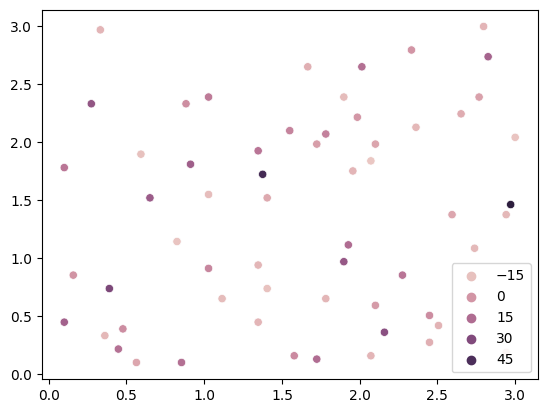

In [11]:
sns.scatterplot(x=l1,y=l2,hue=mll)

In [12]:
kernel = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.376,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[1])

In [13]:
optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
print(log_mll)

[[21.64397793]]


In [14]:
a=0
a_list=[]
mll_list=[]
for i in range (40):
  a=a+0.1
  a_list.append(a)
  kernel = GPy.kern.Matern52(input_dim=1,variance=a,lengthscale=1.376,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[1])

  optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)
  
  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  mll_list.append(mll)
  print(f"log mll {mll}")

log mll [[70.15022514]]
log mll [[-9.47154718]]
log mll [[-5.51321041]]
log mll [[-9.51133709]]
log mll [[-18.69259554]]
log mll [[-18.50743865]]
log mll [[-0.2539949]]
log mll [[-6.67585863]]
log mll [[-14.26126983]]
log mll [[12.44057189]]
log mll [[-6.3636482]]
log mll [[-10.94047979]]
log mll [[-0.68934863]]
log mll [[-8.18432819]]
log mll [[-3.42735589]]
log mll [[-19.43309307]]
log mll [[-4.22277976]]
log mll [[-14.85004446]]
log mll [[-13.71955316]]
log mll [[-18.65705608]]
log mll [[7.7472452]]
log mll [[-10.87812998]]
log mll [[-10.86798834]]
log mll [[1.51954345]]
log mll [[11.99616867]]
log mll [[-11.15977104]]
log mll [[-0.56697947]]
log mll [[21.27888894]]
log mll [[-3.88402564]]
log mll [[-8.35867196]]
log mll [[16.4080005]]
log mll [[-14.71528845]]
log mll [[-13.64438918]]
log mll [[-14.15355061]]
log mll [[-14.2306662]]
log mll [[-0.18131906]]
log mll [[-14.5072624]]
log mll [[-14.93598276]]
log mll [[1.13806445]]
log mll [[8.07116432]]


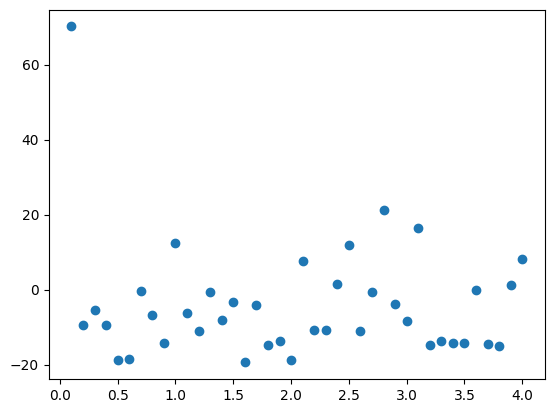

In [15]:
plt.scatter(a_list,mll_list)

In [33]:
kernel = GPy.kern.Matern52(input_dim=1,variance=2.5,lengthscale=1.376,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1.724,active_dims=[1])

optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
print(log_mll)

[[-9.42029674]]


In [27]:
a=0.1
kernel = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=a,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])

optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=20)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))

for i in range (40):
  a=a+0.1
  kernel = GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=a,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])

  optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
  optimizer.run_optimization(max_iter=20)
  X=(optimizer.X)
  m, v = optimizer.model.predict(X)

  
  mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(25))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(25)))
  print(f"log mll {mll}")

log mll [[-1.52047574]]
log mll [[-18.62462452]]
log mll [[1.98380908]]
log mll [[-8.09549317]]
log mll [[-13.83189017]]
log mll [[-21.02867941]]
log mll [[-12.99779395]]
log mll [[-14.35220847]]
log mll [[4.29882442]]
log mll [[8.27412465]]
log mll [[-15.06268388]]
log mll [[-14.13287303]]
log mll [[-11.2550685]]
log mll [[-6.22785782]]
log mll [[-3.59601092]]
log mll [[-6.22676844]]
log mll [[19.9812402]]
log mll [[23.67385585]]
log mll [[15.39598298]]
log mll [[-13.28135453]]
log mll [[17.24883857]]
log mll [[-4.35007884]]
log mll [[-0.29764666]]
log mll [[2.04087755]]
log mll [[-7.91463258]]
log mll [[-17.8673149]]
log mll [[0.11260599]]
log mll [[-3.83911532]]
log mll [[1.97274627]]
log mll [[-9.6788069]]
log mll [[-9.07035536]]
log mll [[-9.79617005]]
log mll [[-9.14910133]]
log mll [[-19.42039476]]
log mll [[-6.14881082]]
log mll [[-3.91117137]]
log mll [[-8.56356481]]
log mll [[2.8388594]]
log mll [[5.75597615]]
log mll [[10.00531944]]


In [36]:
kernel = GPy.kern.Matern52(input_dim=1,variance=1.5,lengthscale=1,active_dims=[0]) \
        * GPy.kern.Matern52(input_dim=1,variance=1,lengthscale=1,active_dims=[1])

optimizer = GPyOpt.methods.BayesianOptimization(f=svm_score, 
                                              domain=bounds,
                                              acquisition_type ='EI',
                                              initial_design_numdata = 5,
                                              model_type='GP',
                                              maximize=True,
                                              kernel=kernel
                                              )
optimizer.run_optimization(max_iter=100)

X=(optimizer.X)
m, v = optimizer.model.predict(X)
log_mll = -0.5*np.matmul(np.matmul((optimizer.Y - m).T,np.linalg.inv(kernel.K(X,X)+(0.01**2)*np.identity(105))),(optimizer.Y - m)) \
        -0.5 * np.log(np.linalg.det(kernel.K(X,X)+(0.01**2)*np.identity(105)))
print(log_mll)

[[-6.73725984]]
